## TO DOs
- Requirements:
    - Best model results and interpretations **(incomplete)**
    - 1 to 3+ business recommendations **(incomplete)**
    - Document string preprocessing function and any other functions
    - Note any code that’s been repurposed and its source
    - Titles and labels on all plots, clean up plots(line plots could be something else? network and t-sne word modeling need to have cleaner appearance)
        - Clean up top positive and negative coefficients from text_feature to give a sense of scale of the coefficients’ impacts
    - Functionalize code
        - Functionalize plotting distributions including by class
        - Functionalize clases balance chart
        - Functionalize running classifiers? Or put them in a loop?
    - Clean up + move imports up to top 
    - Presentation  


- Important to notebook
    - Compare metrics between different classifiers, sampling strategies
    - Better print out the accompanying text, do a list of features that do not have accompanying text in the original df or find their equivalents via indexing?



- Details, can be dropped/modified
    - Detail what min max scaling does and how SVMs are ‘scale sensitive’
    - Iteration through k best and/or recursive feature elimination
    - Interpretation of word model tsne plot 
    - More thorough explanation of cohen’s kappa and evaluation 
    - Finding out when this dataset was gathered

- Later:
    - Blog post
    - Video
    - Do something about @ and mention?
    - Trigrams  and n grams
    -  LDA modeling
    - standardize plot styles

# Designing a reliable product sentiment analyzer: a classification of Tweets regarding Apple and Google

## Business value: 
Being able to reliably classify tweets allows for a jumping off point for further analysis and modeling, as well as more ability to choose which tweets to examine for other use cases.

## Business use case: 
By identifying the negative and positive sentiments about Apple and Google, a tech business from the outside would be able to better understand the strategies, successes and blunders in the eye of the public for two tech giants. This would allow them to better their business by avoiding past mistakes or customer paint points and bouncing off of the successes of these companies.

## Evaluation: 

Cohen's Kappa score has been chosen as the metric of evaluation, especially fit for the imbalanced dataset and measuring the reliability of the classifier, how precise it is compared to being rated by chance. A robust and reliable classifier is needed for this business case due to how noisy and complicated twitter data can be.

# Imports and reading in data: 

In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import yellowbrick
import tensorflow as tf
from yellowbrick.text import TSNEVisualizer
from yellowbrick.text import freqdist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load('en_core_web_sm')

Using TensorFlow backend.
/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from sklearn import metrics
import missingno as msno
import plotly.express as px

In [3]:
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import time
from nltk import FreqDist
from scipy.stats import entropy

In [4]:
plt.style.use('seaborn-talk')
import warnings
warnings.filterwarnings("ignore")

## Reading in data

In [5]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding = "ISO-8859-1")

df.head(20)

tweet_text  \
0   .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1   @jessedee Know about @fludapp ? Awesome iPad/i...   
2   @swonderlin Can not wait for #iPad 2 also. The...   
3   @sxsw I hope this year's festival isn't as cra...   
4   @sxtxstate great stuff on Fri #SXSW: Marissa M...   
5   @teachntech00 New iPad Apps For #SpeechTherapy...   
6                                                 NaN   
7   #SXSW is just starting, #CTIA is around the co...   
8   Beautifully smart and simple idea RT @madebyma...   
9   Counting down the days to #sxsw plus strong Ca...   
10  Excited to meet the @samsungmobileus at #sxsw ...   
11  Find &amp; Start Impromptu Parties at #SXSW Wi...   
12  Foursquare ups the game, just in time for #SXS...   
13  Gotta love this #SXSW Google Calendar featurin...   
14  Great #sxsw ipad app from @madebymany: http://...   
15  haha, awesomely rad iPad app by @madebymany ht...   
16  Holler Gram for iPad on the iTunes App Store -...   
17  I just noticed DST is coming this weekend. How...   
18  Just added my #SXSW flights to @planely. Match...   
19  Must have #SXSW app! RT @malbonster: Lovely re...   

    emotion_in_tweet_is_directed_at  \
0                            iPhone   
1                iPad or iPhone App   
2                              iPad   
3                iPad or iPhone App   
4                            Google   
5                               NaN   
6                               NaN   
7                           Android   
8                iPad or iPhone App   
9                             Apple   
10                          Android   
11                      Android App   
12                      Android App   
13  Other Google product or service   
14               iPad or iPhone App   
15               iPad or iPhone App   
16                              NaN   
17                           iPhone   
18               iPad or iPhone App   
19               iPad or iPhone App   

   is_there_an_emotion_directed_at_a_brand_or_product  
0                                    Negative emotion  
1                                    Positive emotion  
2                                    Positive emotion  
3                                    Negative emotion  
4                                    Positive emotion  
5                  No emotion toward brand or product  
6                  No emotion toward brand or product  
7                                    Positive emotion  
8                                    Positive emotion  
9                                    Positive emotion  
10                                   Positive emotion  
11                                   Positive emotion  
12                                   Positive emotion  
13                                   Positive emotion  
14                                   Positive emotion  
15                                   Positive emotion  
16                 No emotion toward brand or product  
17                                   Negative emotion  
18                                   Positive emotion  
19                                   Positive emotion

In [6]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

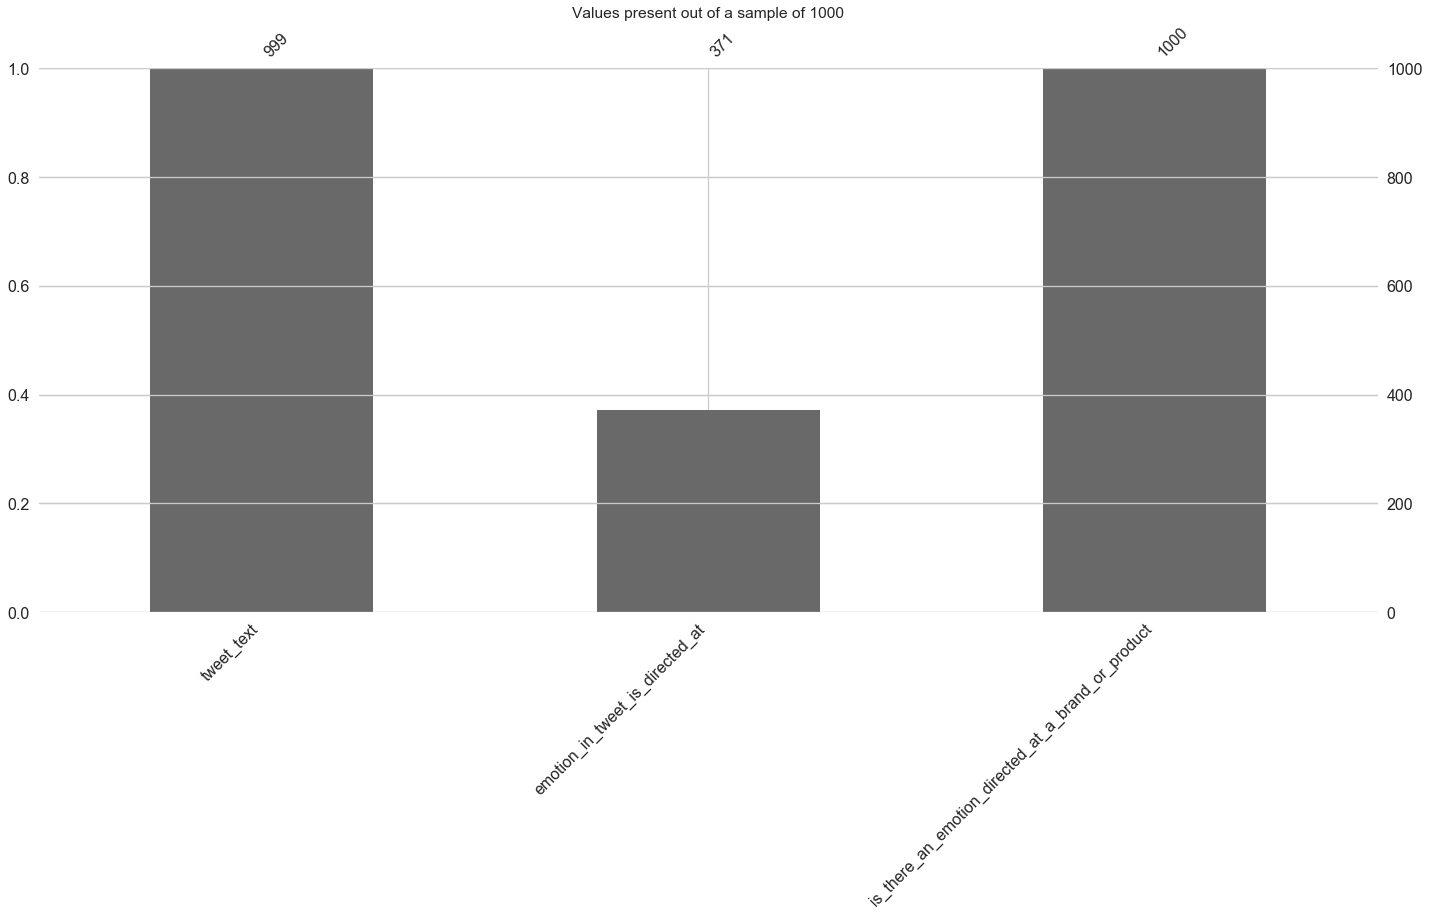

In [11]:
msno.bar(df.sample(1000))
ax = plt.gca()
ax.set_title("Values present out of a sample of 1000")
plt.show()

## Dropping product/company tweet emotion is directed at
### Rationale: 
Dropping this feature to focus on the text itself and later, statistics regarding the text, to make a more generalizable classifier than including information about the direction of the tweet, as well as a significant amount of null values compromising this feature.

In [12]:
df = df.drop('emotion_in_tweet_is_directed_at', axis=1)

df.isnull().sum()

tweet_text                                            1
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

## Severe class imbalance of Neutral type tweets vs. Positive and especially Negative tweets

In [13]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna=False)

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [14]:
df = df.dropna()

In [15]:
df.isnull().sum()

tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

Text(0.5, 1.0, 'Values present out of a sample of 1000 - after cleaning')

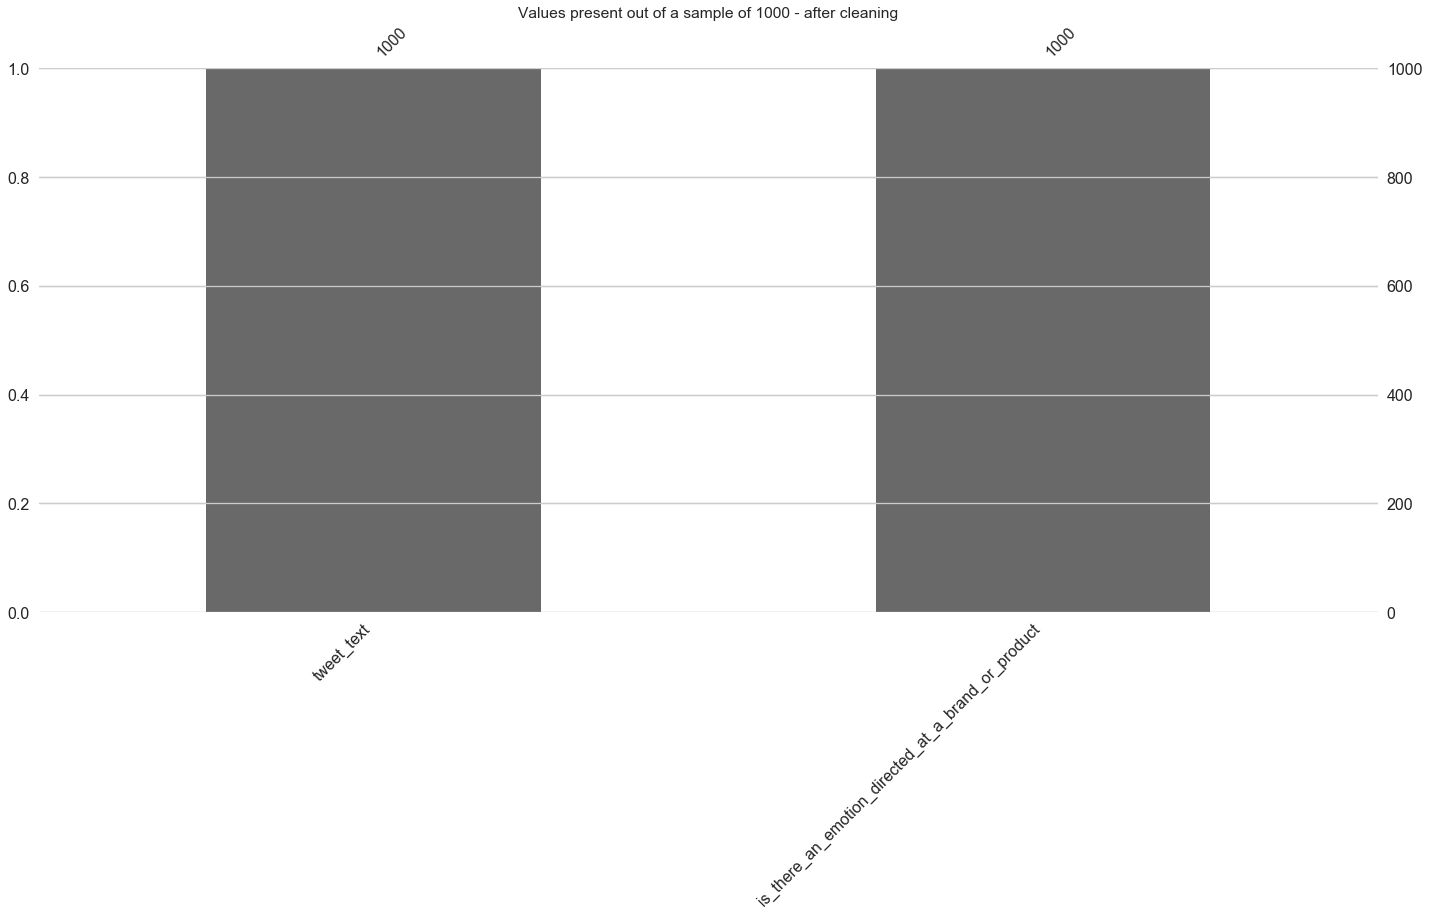

In [17]:
msno.bar(df.sample(1000))
ax = plt.gca()
ax.set_title("Values present out of a sample of 1000 - after cleaning")

# Preprocessing and EDA

## Renaming columns

In [18]:
df = df.rename(columns={"tweet_text": "text", "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"})
df

text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

                               sentiment  
0                       Negative emotion  
1                       Positive emotion  
2                       Positive emotion  
3                       Negative emotion  
4                       Positive emotion  
...                                  ...  
9088                    Positive emotion  
9089  No emotion toward brand or product  
9090  No emotion toward brand or product  
9091  No emotion toward brand or product  
9092  No emotion toward brand or product  

[9092 rows x 2 columns]

## Mapping sentiment to increasingly positive: 0 for negative, 1 for neutral, 2 for positive

In [19]:
df.sentiment = df.sentiment.map({'Positive emotion': 2, 'Negative emotion': 0, 'No emotion toward brand or product': 1, "I can't tell":1})

In [20]:
df.sentiment.value_counts(dropna=False)

1    5544
2    2978
0     570
Name: sentiment, dtype: int64

## Countplot shows that the majority of tweets are neutral, then positive, then few negative tweets

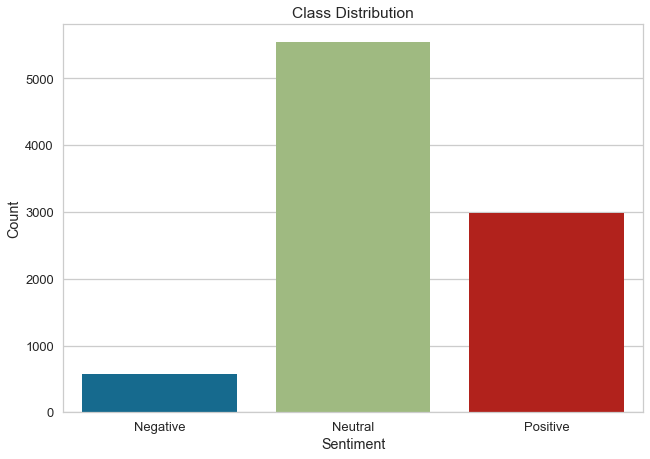

In [21]:
sns.countplot(df.sentiment)
ax = plt.gca()
ax.set_title("Class Distribution")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")
ax.set_xticklabels(['Negative','Neutral','Positive'])
plt.show()

## General text preprocessing function, creating a new dataframe(clean_df) to preserve the original text

In [23]:
def preprocess(text):
    '''docstring goes here'''
    text = text.str.replace("(<br/>)", "")
    text = text.str.replace('(<a).*(>).*(</a>)', '')
    text = text.str.replace('(&amp)', '')
    text = text.str.replace('(&gt)', '')
    text = text.str.replace('(&lt)', '')
    text = text.str.replace('(\xa0)', ' ')  
    text = text.str.replace(',','')
    text = text.str.replace('{', '')
    text = text.str.replace('}', '')
    text = text.str.replace('.', '')
    text = text.str.replace(':', '')
    text = text.str.replace('-', '')
    text = text.str.replace('(', '')
    text = text.str.replace(')', '')
    return text

clean_df = df 
clean_df['text'] = preprocess(clean_df['text'])

clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

## Creating new features
Creating features out of the length of a tweet, words in a tweet, and amounts of hashtags, capital words, exclamation/question marks, the mean length of a word in a tweet, the count of unique words in a tweet, and the percentage of unique words in a tweet.

In [24]:
def tweet_special_count(string, character):
    '''Splits string by word, and returns the count of a given character in a tweet'''
    w = string.split()
    
    char = [word for word in w if word.startswith(character)]
    
    return len(char)

In [25]:
clean_df['tweet_len'] = clean_df['text'].astype(str).apply(len)
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_df["mean_word_len"] = clean_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
clean_df['count_unique_word']=clean_df["text"].apply(lambda x: len(set(str(x).split())))
clean_df['word_unique_percent']=clean_df['count_unique_word']*100/clean_df['tweet_words']
clean_df.head()



text  sentiment  tweet_len  \
0  @wesley83 I have a 3G iPhone After 3 hrs tweet...          0        122   
1  @jessedee Know about @fludapp ? Awesome iPad/i...          2        137   
2  @swonderlin Can not wait for #iPad 2 also They...          2         77   
3  @sxsw I hope this year's festival isn't as cra...          0         81   
4  @sxtxstate great stuff on Fri #SXSW Marissa Ma...          2        119   

   tweet_words  hash_cnt  mention_cnt  capital_words  excl_q_marks  \
0           23         2            1              1             1   
1           22         1            2              1             1   
2           15         2            1              1             0   
3           15         1            1              0             0   
4           17         1            1              1             0   

   mean_word_len  count_unique_word  word_unique_percent  
0       4.304348                 21            91.304348  
1       5.272727                 22           100.000000  
2       4.200000                 15           100.000000  
3       4.466667                 12            80.000000  
4       6.058824                 17           100.000000

In [26]:
clean_df.columns

Index(['text', 'sentiment', 'tweet_len', 'tweet_words', 'hash_cnt',
       'mention_cnt', 'capital_words', 'excl_q_marks', 'mean_word_len',
       'count_unique_word', 'word_unique_percent'],
      dtype='object')

# Summary stats and visuals

## Top tokens - items and products with named entity recognition

In [27]:
df.text

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

In [28]:
from collections import Counter
tokens = nlp(''.join(str(df.text.tolist())))
items = [x.text for x in tokens.ents]
Counter(items).most_common(20)

[('Apple', 1126),
 ('iPhone', 839),
 ('Google', 771),
 ('SXSW', 741),
 ('Austin', 640),
 ('2', 476),
 ('today', 299),
 ('#sxsw #', 266),
 ('#sxsw', 235),
 ('#SXSW #', 234),
 ('Today', 232),
 ('Android', 229),
 ('Launch Major New Social Network', 155),
 ('sxsw', 149),
 ('Circles', 142),
 ('RT @mention', 138),
 ('SxSW', 106),
 ("'RT @mention", 94),
 ('RT @mention Google', 93),
 ('iPad2', 92)]

## Between Apple and its iPad 2, Apple seems to dominate over Google in this dataset. 
Of interest is "Circles", the new Google social network launch rumored at the time (evidently during South by Southwest Festival in Austin, Texas)[TBD: link].

### Most common tokens W/ identified Entities

In [29]:
item_cnt = Counter(items).most_common(20)
df_items = pd.DataFrame(item_cnt, columns =['text', 'count'])


fig = px.bar(df_items, y="text", x="count", orientation='h',title="Most Common Tokens W/ Entities Mentioned")
fig.show()

### Most Common Products

In [30]:
products = []
for ent in tokens.ents:
    if ent.label_ == 'PRODUCT':
        products.append(ent.text)
        
prdct_cnt = Counter(products).most_common(20)
df_prod = pd.DataFrame(prdct_cnt, columns =['text', 'count'])

fig = px.bar(df_prod, y="text", x="count", orientation='h',title="Most Common Products Mentioned")
fig.show()

## Analysis of numerical features- TBD: Class-by-class, more full writeup
### Distributions:
Tweet length, amount of words in tweet, and count of unique words stand out as look Gaussian/normal.

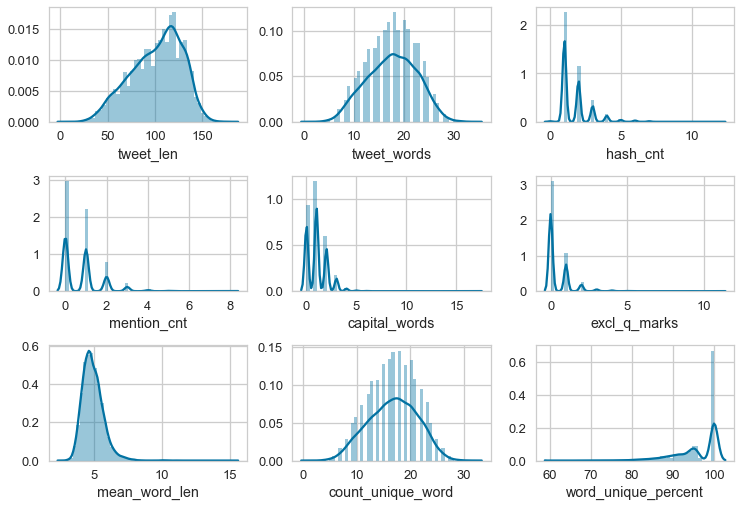

In [31]:
fig, axs = plt.subplots(ncols=3, nrows=3)
sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(clean_df['tweet_words'], ax=axs[0][1])
sns.distplot(clean_df['hash_cnt'], ax=axs[0][2])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][0])
sns.distplot(clean_df['capital_words'], ax=axs[1][1])
sns.distplot(clean_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(clean_df['mean_word_len'], ax=axs[2][0])
sns.distplot(clean_df['count_unique_word'], ax=axs[2][1])
sns.distplot(clean_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

### Correlation matrix - looks like not much correlation/colinearity, no values above +.30 and none below -.45

Text(0.5, 1, 'Correlation of numerical features(diagonal removed)')

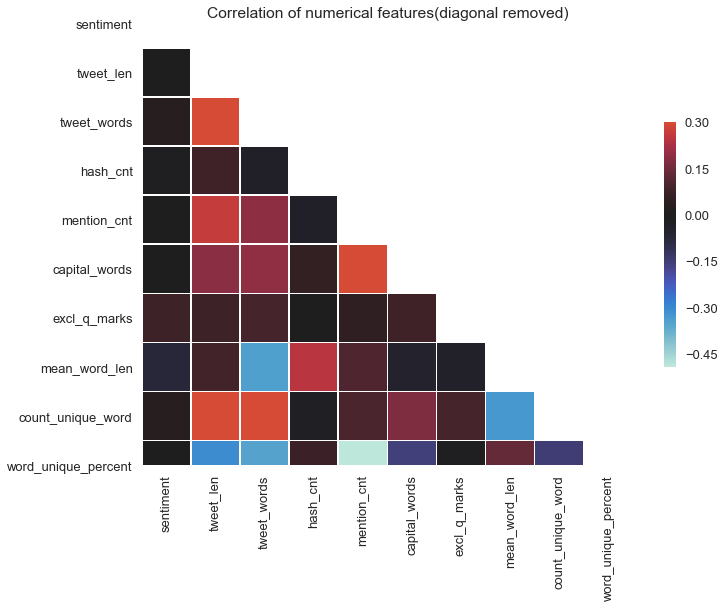

In [34]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax = plt.gca()
ax.set_title("Correlation of numerical features(diagonal removed)")

### Pairplot

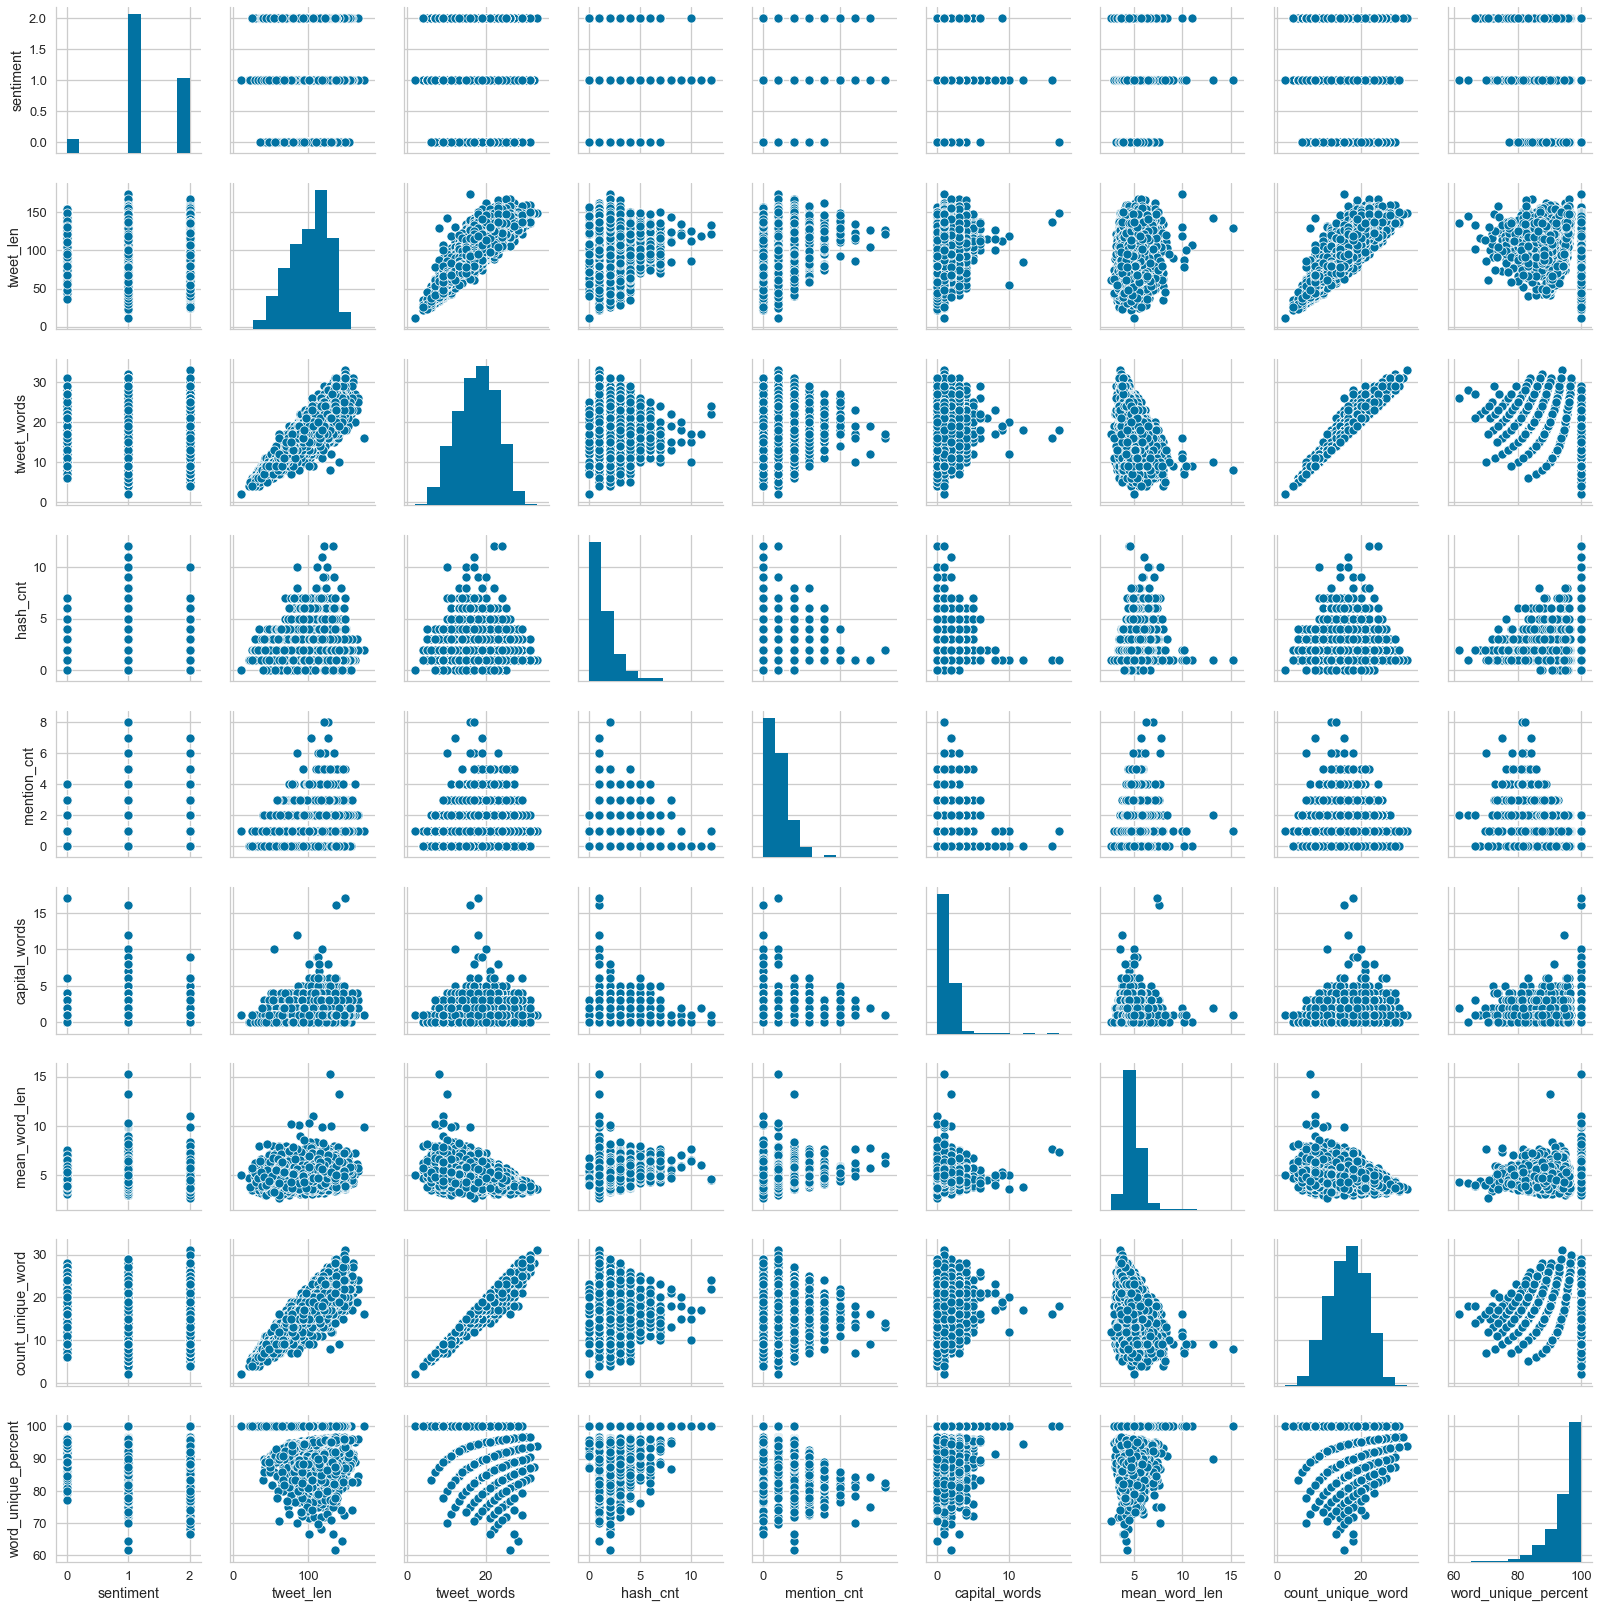

In [35]:
sns.pairplot(clean_df[[ 'sentiment', 'tweet_len','tweet_words',
       'hash_cnt', 'mention_cnt', 'capital_words','mean_word_len', 'count_unique_word', 'word_unique_percent']])

#### Dropping tweet_len due to high correlation with tweet_words and unique words

In [36]:
clean_df = clean_df.drop('tweet_len',axis=1)

clean_df.head()

text  sentiment  tweet_words  \
0  @wesley83 I have a 3G iPhone After 3 hrs tweet...          0           23   
1  @jessedee Know about @fludapp ? Awesome iPad/i...          2           22   
2  @swonderlin Can not wait for #iPad 2 also They...          2           15   
3  @sxsw I hope this year's festival isn't as cra...          0           15   
4  @sxtxstate great stuff on Fri #SXSW Marissa Ma...          2           17   

   hash_cnt  mention_cnt  capital_words  excl_q_marks  mean_word_len  \
0         2            1              1             1       4.304348   
1         1            2              1             1       5.272727   
2         2            1              1             0       4.200000   
3         1            1              0             0       4.466667   
4         1            1              1             0       6.058824   

   count_unique_word  word_unique_percent  
0                 21            91.304348  
1                 22           100.000000  
2                 15           100.000000  
3                 12            80.000000  
4                 17           100.000000

# Further preprocessing - tokenizing and lemmatizing, stopword removal

In [37]:
clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

## Initial Wordcloud for comparison of prominent text

In [38]:
from wordcloud import WordCloud

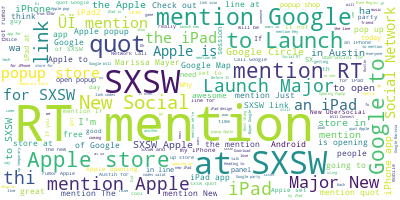

In [41]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

## Sentence by sentence stemming and visualization

In [42]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def stem_sentences(sentence):
    tokens = sentence.split()
    lemma_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemma_tokens)

clean_df['text'] = clean_df['text'].apply(stem_sentences)

clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hr tweeti...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't a cras...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customer complained their ...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

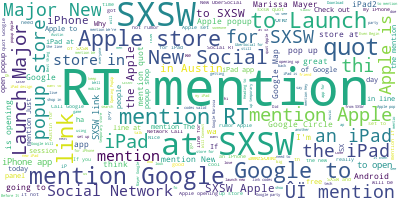

In [43]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

## Removal of stopwords and corresponding visual

In [44]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelburak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
clean_df['text'] = clean_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))

clean_df['text']

0       @wesley83 I 3G iPhone After 3 hr tweeting #RIS...
1       @jessedee Know @fludapp ? Awesome iPad/iPhone ...
2       @swonderlin Can wait #iPad 2 also They sale #SXSW
3       @sxsw I hope year's festival crashy year's iPh...
4       @sxtxstate great stuff Fri #SXSW Marissa Mayer...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt regularly s...
9090    Google's Zeiger physician never reported poten...
9091    Some Verizon iPhone customer complained time f...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

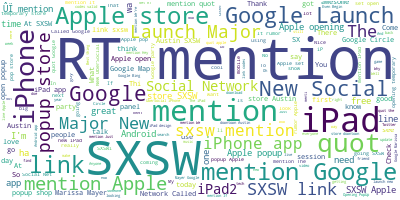

In [46]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

# Features after cleaning and analysis

In [47]:
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_df["mean_word_len"] = clean_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
clean_df['count_unique_word']=clean_df["text"].apply(lambda x: len(set(str(x).split())))
clean_df['word_unique_percent']=clean_df['count_unique_word']*100/clean_df['tweet_words']
clean_df.head()

text  sentiment  tweet_words  \
0  @wesley83 I 3G iPhone After 3 hr tweeting #RIS...          0           17   
1  @jessedee Know @fludapp ? Awesome iPad/iPhone ...          2           16   
2  @swonderlin Can wait #iPad 2 also They sale #SXSW          2            9   
3  @sxsw I hope year's festival crashy year's iPh...          0           10   
4  @sxtxstate great stuff Fri #SXSW Marissa Mayer...          2           16   

   hash_cnt  mention_cnt  capital_words  excl_q_marks  mean_word_len  \
0         2            1              1             1       4.882353   
1         1            2              1             1       5.812500   
2         2            1              1             0       4.555556   
3         1            1              0             0       5.000000   
4         1            1              1             0       6.312500   

   count_unique_word  word_unique_percent  
0                 16            94.117647  
1                 16           100.000000  
2                  9           100.000000  
3                  9            90.000000  
4                 16           100.000000

## Distribution of features: 
The distribution of features remains similar, likely due to mostly preserving word content.

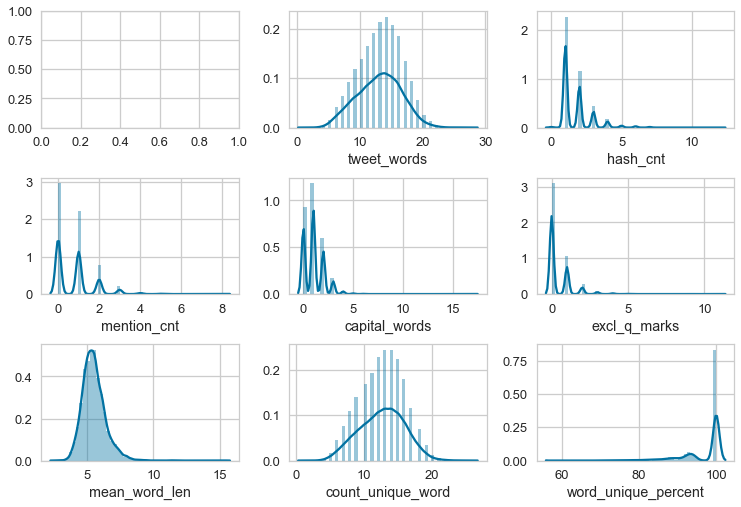

In [48]:
fig, axs = plt.subplots(ncols=3, nrows=3)
# sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(clean_df['tweet_words'], ax=axs[0][1])
sns.distplot(clean_df['hash_cnt'], ax=axs[0][2])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][0])
sns.distplot(clean_df['capital_words'], ax=axs[1][1])
sns.distplot(clean_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(clean_df['mean_word_len'], ax=axs[2][0])
sns.distplot(clean_df['count_unique_word'], ax=axs[2][1])
sns.distplot(clean_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

## Creating negative and positive dataframes

In [49]:
pos_df = clean_df.loc[clean_df['sentiment'] == 2]
neg_df = clean_df.loc[clean_df['sentiment'] == 0]
pos_df.head()

text  sentiment  tweet_words  \
1  @jessedee Know @fludapp ? Awesome iPad/iPhone ...          2           16   
2  @swonderlin Can wait #iPad 2 also They sale #SXSW          2            9   
4  @sxtxstate great stuff Fri #SXSW Marissa Mayer...          2           16   
7  #SXSW starting #CTIA around corner #googleio h...          2           13   
8  Beautifully smart simple idea RT @madebymany @...          2           13   

   hash_cnt  mention_cnt  capital_words  excl_q_marks  mean_word_len  \
1         1            2              1             1       5.812500   
2         2            1              1             0       4.555556   
4         1            1              1             0       6.312500   
7         4            0              2             0       5.307692   
8         2            2              1             1       7.461538   

   count_unique_word  word_unique_percent  
1                 16                100.0  
2                  9                100.0  
4                 16                100.0  
7                 13                100.0  
8                 13                100.0

In [50]:
neg_df.head()

text  sentiment  tweet_words  \
0   @wesley83 I 3G iPhone After 3 hr tweeting #RIS...          0           17   
3   @sxsw I hope year's festival crashy year's iPh...          0           10   
17  I noticed DST coming weekend How many iPhone u...          0           17   
38  @mention False Alarm Google Circles Not Coming...          0           16   
64   Again? RT @mention Line Apple store insane #sxsw          0            8   

    hash_cnt  mention_cnt  capital_words  excl_q_marks  mean_word_len  \
0          2            1              1             1       4.882353   
3          1            1              0             0       5.000000   
17         2            0              3             1       4.882353   
38         4            1              1             1       6.000000   
64         1            1              1             1       5.125000   

    count_unique_word  word_unique_percent  
0                  16            94.117647  
3                   9            90.000000  
17                 17           100.000000  
38                 15            93.750000  
64                  8           100.000000

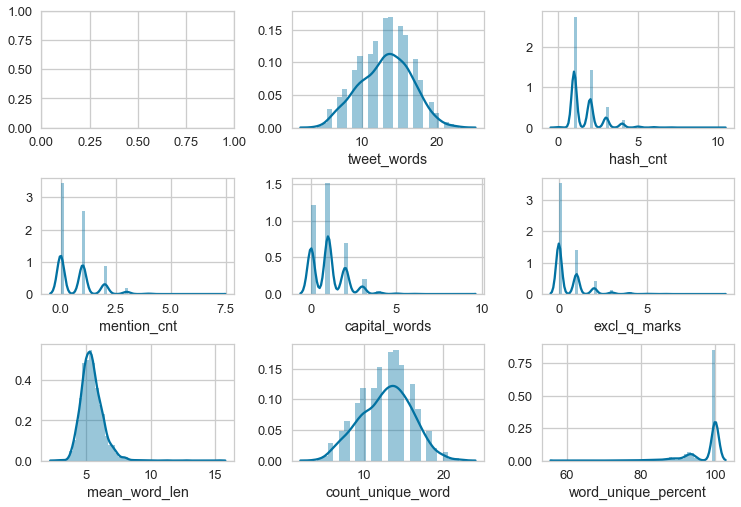

In [51]:
fig, axs = plt.subplots(ncols=3, nrows=3)
# sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(pos_df['tweet_words'], ax=axs[0][1])
sns.distplot(pos_df['hash_cnt'], ax=axs[0][2])
sns.distplot(pos_df['mention_cnt'], ax=axs[1][0])
sns.distplot(pos_df['capital_words'], ax=axs[1][1])
sns.distplot(pos_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(pos_df['mean_word_len'], ax=axs[2][0])
sns.distplot(pos_df['count_unique_word'], ax=axs[2][1])
sns.distplot(pos_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

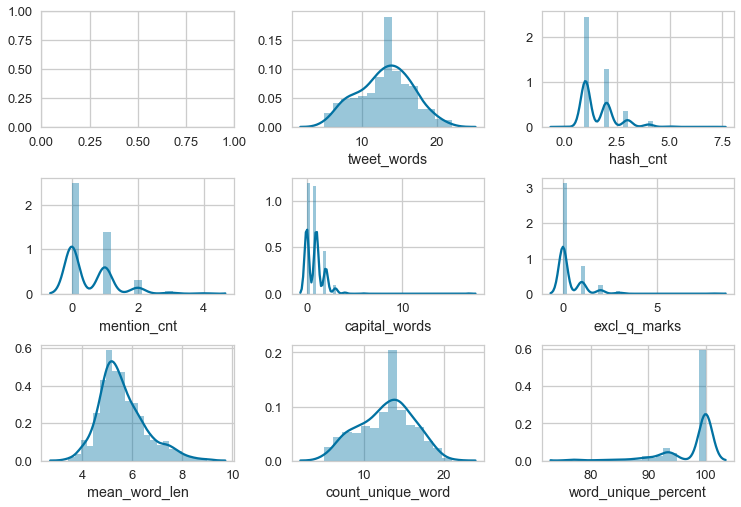

In [52]:
fig, axs = plt.subplots(ncols=3, nrows=3)
# sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(neg_df['tweet_words'], ax=axs[0][1])
sns.distplot(neg_df['hash_cnt'], ax=axs[0][2])
sns.distplot(neg_df['mention_cnt'], ax=axs[1][0])
sns.distplot(neg_df['capital_words'], ax=axs[1][1])
sns.distplot(neg_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(neg_df['mean_word_len'], ax=axs[2][0])
sns.distplot(neg_df['count_unique_word'], ax=axs[2][1])
sns.distplot(neg_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

## Tokenizing with TweetTokenizer

In [53]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
clean_df['tokens'] = clean_df['text'].apply(tt.tokenize)

# Visuals, continued - t-Sne

## t-SNE of k-means clusters, overall document, text vs. classes

In [54]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(clean_df['text'])

tf_words = tfidf.get_feature_names()


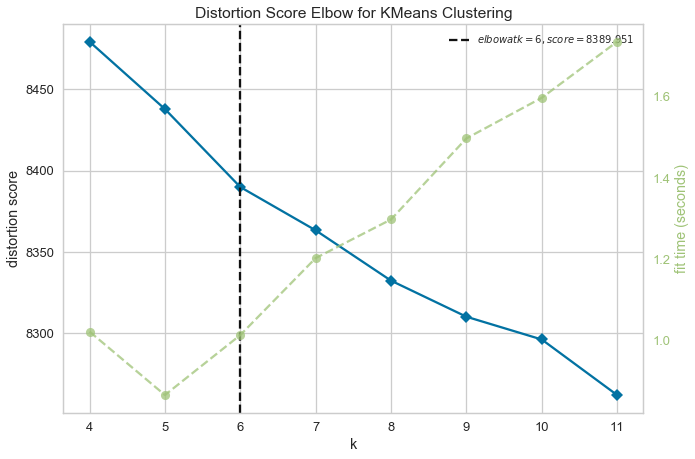

In [59]:
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)
visualizer.show() 

### t-SNE of K-means

In [60]:
from yellowbrick.text import TSNEVisualizer


In [61]:
clusters = KMeans(n_clusters=6)
clusters.fit(X)


KMeans(n_clusters=6)

### Interpretation:
Of special interest are groups of words regarding the rumored launch of Google's "Circles" and a special Apple popup store in Austin that seems popular. More analysis needs to go into the positioning and relationship of clusters, TBD.

W0702 10:26:35.232653 4562693568 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0702 10:26:35.264666 4562693568 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0702 10:26:35.277509 4562693568 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0702 1

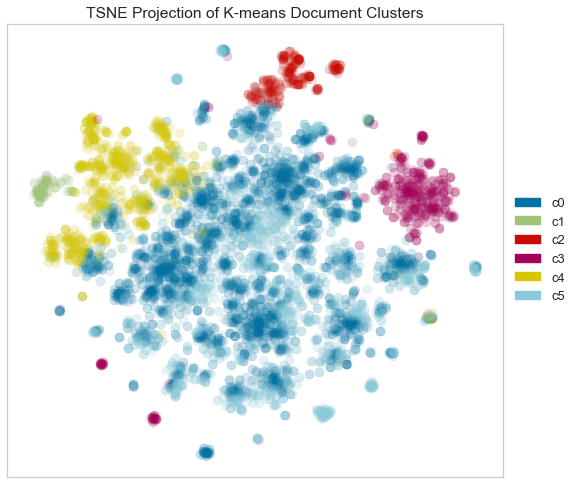

0 : sxsw, google, ipad, link, mention, iphone, app, android, apple, rt
1 : opening, downtown, temporary, austin, store, launch, apple, rumor, mention, it
2 : network, social, circles, called, launch, major, new, today, possibly, google
3 : quot, mention, sxsw, google, rt, ipad, apple, heard, link, go
4 : apple, store, popup, sxsw, link, austin, mention, ipad2, line, open
5 : mention, rt, link, sxsw, iphone, app, ipad, google, free, new


In [62]:
tsne = TSNEVisualizer(size=(800, 600), title="TSNE Projection of K-means Document Clusters", alpha=0.1,random_state=0)
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.show()
common_words = clusters.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(tf_words[word] for word in centroid))
    


### TSNE of tweet text
### Interpretation: 
The documents cluster very much around the center, but there are plenty of outlying documents.

W0702 10:28:18.257611 4562693568 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


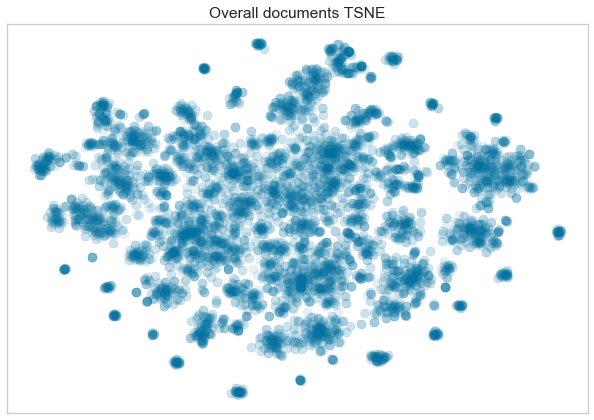

In [69]:
tsne = TSNEVisualizer(random_state=0,alpha=0.1, title="Overall documents TSNE")
tsne.fit(X)
tsne.show()

### TSNE of tweet text and sentiment
### Interpretation:
Neutral sentiment dominates, fitting with the class imbalance. Negative classes can hardly be seen in this projection, while there are some outlying positive class records.

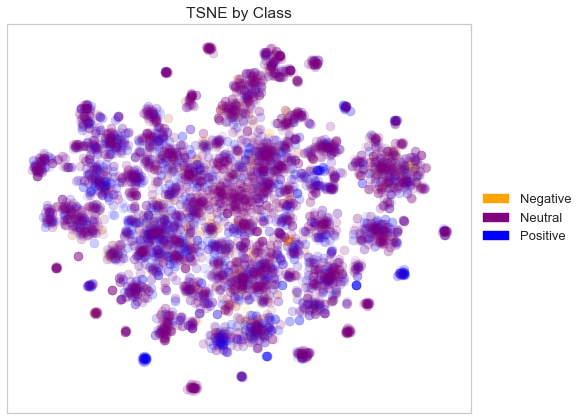

In [70]:
y = clean_df['sentiment'].replace({0:"Negative",1:"Neutral",2:"Positive"})
tsne = TSNEVisualizer(random_state=0, title="TSNE by Class",colors=('orange','purple','blue'), alpha=0.1)
tsne.fit(X,y)

tsne.show()

### Word modeling t-SNE

In [164]:
from gensim.models import word2vec
from sklearn.manifold import TSNE

In [165]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['text']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(clean_df)        
corpus[0:2]

[['@wesley83',
  'I',
  '3G',
  'iPhone',
  'After',
  '3',
  'hr',
  'tweeting',
  '#RISE_Austin',
  'wa',
  'dead!',
  'I',
  'need',
  'upgrade',
  'Plugin',
  'station',
  '#SXSW'],
 ['@jessedee',
  'Know',
  '@fludapp',
  '?',
  'Awesome',
  'iPad/iPhone',
  'app',
  'likely',
  'appreciate',
  'design',
  'Also',
  "they're",
  'giving',
  'free',
  'Ts',
  '#SXSW']]

In [166]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv['Google']

array([-0.23100507, -0.08668734, -0.13747317, -0.12835744,  0.23740438,
        0.3270656 ,  0.01144834, -0.1844263 , -0.1520866 , -0.31654286,
       -0.01728158,  0.258529  ,  0.06925409,  0.23432474,  0.0243816 ,
       -0.12515898,  0.37832227, -0.18966192,  0.02760287, -0.33957848,
       -0.22762237,  0.19612548, -0.04621776,  0.0995967 ,  0.0939536 ,
        0.03242289,  0.3924643 , -0.11754343, -0.1847687 , -0.2595373 ,
       -0.05188397,  0.06048289, -0.18623619, -0.04901778, -0.27040258,
        0.4335534 ,  0.18473084, -0.09579014, -0.06873488,  0.04331101,
       -0.1597796 , -0.05950716, -0.05411011,  0.09934561, -0.5033609 ,
        0.3767784 , -0.06789522,  0.10672756,  0.04977375,  0.22646803,
        0.55979025, -0.00493417,  0.08295201,  0.19442199,  0.05094203,
       -0.29153156,  0.2926613 ,  0.09858625, -0.11288389, -0.07640167,
        0.3010914 ,  0.28089836,  0.3524474 ,  0.22453739, -0.22682881,
       -0.24441692,  0.06930014, -0.18480478, -0.01115563,  0.04

### TBD: Interpretation

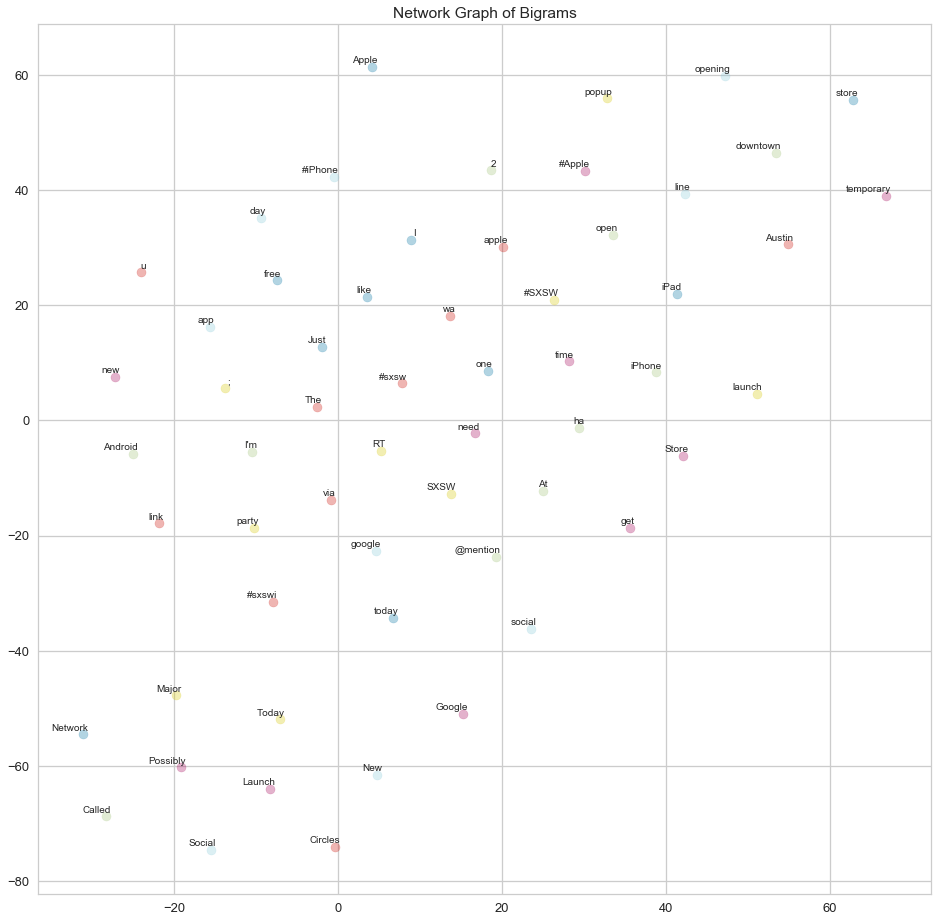

In [167]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], alpha=0.3)
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title("Network Graph of Bigrams")
    plt.show()
tsne_plot(model)

# Word2Vec Similarities and plots

## Google interpretation: 
Google's word similarities heavily center around the launch of the Circles network rumored at the time.

In [71]:
google_similar = model.most_similar('Google')

google_similar

[('New', 0.9869552254676819),
 ('Social', 0.9837697744369507),
 ('Circles', 0.9820963144302368),
 ('Possibly', 0.9799824953079224),
 ('Network', 0.9792370796203613),
 ('Launch', 0.976809024810791),
 ('Today', 0.9755456447601318),
 ('Major', 0.975350558757782),
 ('Called', 0.9718084335327148),
 ('social', 0.9426686763763428)]

Text(0.5, 1.0, "Word Similarities to 'Google'")

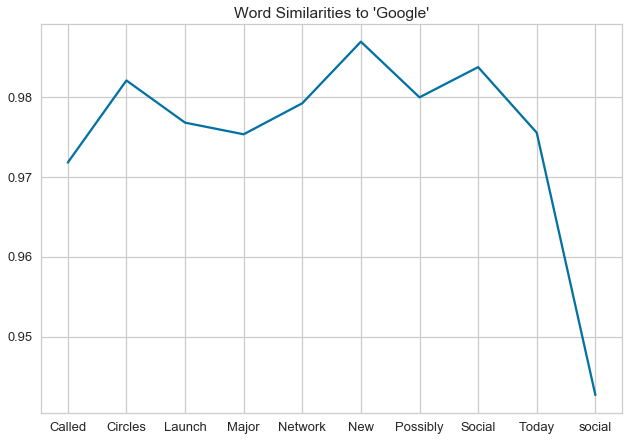

In [85]:
sns.lineplot(*zip(*google_similar))
ax = plt.gca()
ax.set_title("Word Similarities to 'Google'")

## Apple interpretation:
Apple's word similarities heavily focus on the opening of a temporary popup store in downtown Austin and the iPad 2.

In [86]:
apple_similar = model.most_similar('Apple')

Text(0.5, 1.0, "Word Similarities to 'Apple'")

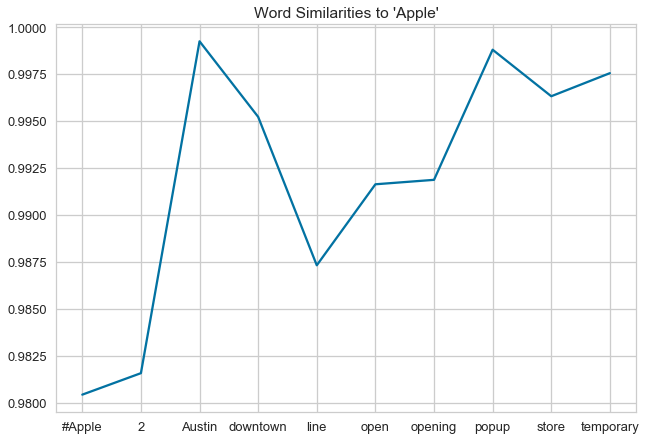

In [87]:
sns.lineplot(*zip(*apple_similar))
ax = plt.gca()
ax.set_title("Word Similarities to 'Apple'")

# Bigrams and trigrams

In [161]:
from nltk import bigrams
from nltk import trigrams

In [162]:
clean_df['tokens']

0       [@wesley83, I, 3G, iPhone, After, 3, hr, tweet...
1       [@jessedee, Know, @fludapp, ?, Awesome, iPad, ...
2       [@swonderlin, Can, wait, #iPad, 2, also, They,...
3       [@sxsw, I, hope, year's, festival, crashy, yea...
4       [@sxtxstate, great, stuff, Fri, #SXSW, Marissa...
                              ...                        
9088                      [Ipad, everywhere, #SXSW, link]
9089    [Wave, buzz, RT, @mention, We, interrupt, regu...
9090    [Google's, Zeiger, physician, never, reported,...
9091    [Some, Verizon, iPhone, customer, complained, ...
9092    [, Ï, ¡, , Ïà, , ü_, , , Ê, , , Î, , ...
Name: tokens, Length: 9092, dtype: object

In [90]:
#create bigrams
bigram_list = [list(bigrams(tweet)) for tweet in clean_df['tokens']]

bigram_list[:6]

[[('@wesley83', 'I'),
  ('I', '3G'),
  ('3G', 'iPhone'),
  ('iPhone', 'After'),
  ('After', '3'),
  ('3', 'hr'),
  ('hr', 'tweeting'),
  ('tweeting', '#RISE_Austin'),
  ('#RISE_Austin', 'wa'),
  ('wa', 'dead'),
  ('dead', '!'),
  ('!', 'I'),
  ('I', 'need'),
  ('need', 'upgrade'),
  ('upgrade', 'Plugin'),
  ('Plugin', 'station'),
  ('station', '#SXSW')],
 [('@jessedee', 'Know'),
  ('Know', '@fludapp'),
  ('@fludapp', '?'),
  ('?', 'Awesome'),
  ('Awesome', 'iPad'),
  ('iPad', '/'),
  ('/', 'iPhone'),
  ('iPhone', 'app'),
  ('app', 'likely'),
  ('likely', 'appreciate'),
  ('appreciate', 'design'),
  ('design', 'Also'),
  ('Also', "they're"),
  ("they're", 'giving'),
  ('giving', 'free'),
  ('free', 'Ts'),
  ('Ts', '#SXSW')],
 [('@swonderlin', 'Can'),
  ('Can', 'wait'),
  ('wait', '#iPad'),
  ('#iPad', '2'),
  ('2', 'also'),
  ('also', 'They'),
  ('They', 'sale'),
  ('sale', '#SXSW')],
 [('@sxsw', 'I'),
  ('I', 'hope'),
  ('hope', "year's"),
  ("year's", 'festival'),
  ('festival', 'cras

In [91]:
flat_bigrams = [item for sublist in bigram_list for item in sublist]

flat_bigrams[:11]

[('@wesley83', 'I'),
 ('I', '3G'),
 ('3G', 'iPhone'),
 ('iPhone', 'After'),
 ('After', '3'),
 ('3', 'hr'),
 ('hr', 'tweeting'),
 ('tweeting', '#RISE_Austin'),
 ('#RISE_Austin', 'wa'),
 ('wa', 'dead'),
 ('dead', '!')]

## Top 20 bigrams

## Interpretation:
The bigrams are dominated by phrases regarding this social network mentioned above, as well as the iPad2 and popup store again.

In [92]:
import itertools
from collections import Counter

bigram_count = Counter(flat_bigrams)

bigram_count.most_common(20)

[(('RT', '@mention'), 2854),
 (('iPad', '2'), 989),
 (('@mention', '@mention'), 567),
 (('link', '#sxsw'), 513),
 (('#SXSW', 'link'), 460),
 (('@mention', 'Google'), 363),
 (('via', '@mention'), 346),
 (('Social', 'Network'), 308),
 (('New', 'Social'), 292),
 (('@mention', '#sxsw'), 279),
 (('Network', 'Called'), 277),
 (('!', 'link'), 272),
 (('Major', 'New'), 267),
 (('Launch', 'Major'), 266),
 (('Called', 'Circles'), 255),
 (('popup', 'store'), 254),
 (('#sxsw', 'link'), 254),
 (('Google', 'Launch'), 253),
 (('link', '#SXSW'), 243),
 (('Apple', 'Store'), 236)]

In [93]:
bigram_df = pd.DataFrame(bigram_count.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

bigram  count
0         (RT, @mention)   2854
1              (iPad, 2)    989
2   (@mention, @mention)    567
3          (link, #sxsw)    513
4          (#SXSW, link)    460
5     (@mention, Google)    363
6        (via, @mention)    346
7      (Social, Network)    308
8          (New, Social)    292
9      (@mention, #sxsw)    279
10     (Network, Called)    277
11             (!, link)    272
12          (Major, New)    267
13       (Launch, Major)    266
14     (Called, Circles)    255
15        (popup, store)    254
16         (#sxsw, link)    254
17      (Google, Launch)    253
18         (link, #SXSW)    243
19        (Apple, Store)    236

## Plot of top 20 bigrams

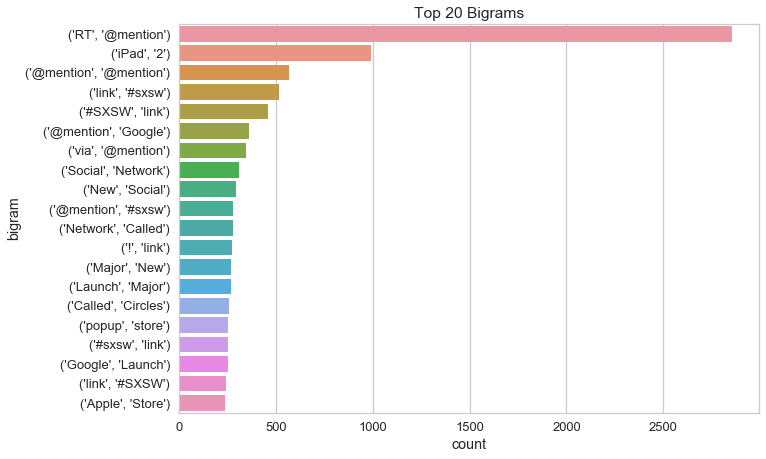

In [98]:
sns.barplot(data=bigram_df, x="count", y="bigram")
ax = plt.gca()
ax.set_title("Top 20 Bigrams")
plt.show()

## Network plot of bigrams

### Interpretation: 
Clearly there's links between bigrams in tweets about the new social network, and the Apple popup store, when network graphed.

In [99]:
import networkx as nx


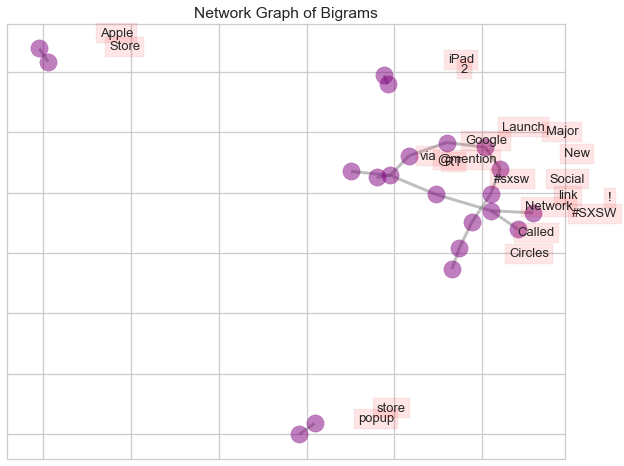

In [101]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

# G.add_node("apple", weight=100)

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2, seed=33)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=12,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax,
                alpha=0.5)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.175, value[1]+.050
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.1),
            horizontalalignment='center', fontsize=13)
ax.set_title("Network Graph of Bigrams")
plt.show()

### TBD: LDA visualization
https://www.kaggle.com/ktattan/lda-and-document-similarity

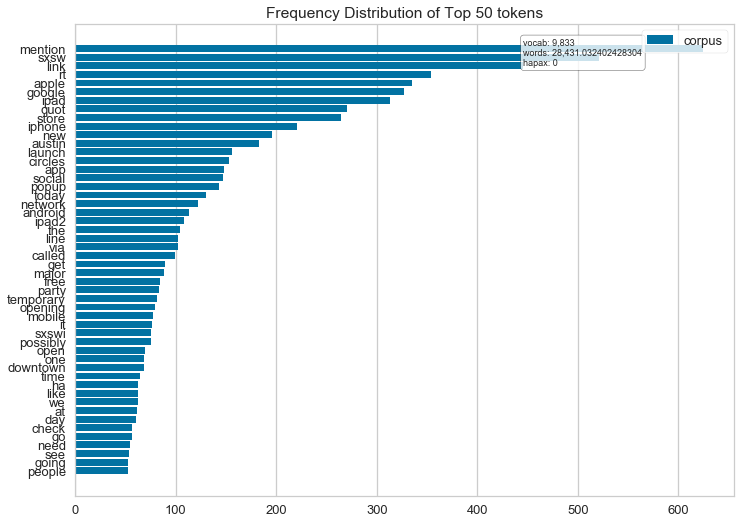

In [102]:
from yellowbrick.text import FreqDistVisualizer
visualizer = FreqDistVisualizer(features=tf_words)
visualizer.fit(X)
plt.tight_layout()
visualizer.poof()

# Modeling

## TBD: Multiple classifiers, tuning, better display of metrics, feature impact

In [103]:
from sklearn_pandas import DataFrameMapper, cross_val_score

## Making a scorer for grid searching out of cohen's kappa

In [104]:
from sklearn.metrics import cohen_kappa_score, make_scorer
kappa_scorer = make_scorer(cohen_kappa_score)

## DataFrameMapper with Tf-idf Vectorization
Note: DataFrameMapper creates a union between features, resulting in an array. TF-IDF, put simply, is a vectorization technique that takes the number of times the word appears / the number of documents containing the words, most helpfullly normalizing word frequency by dividing by the document frequency to weight common words downwards as they appear many times but in many documents, vs. other permutations of frequencies.

In [105]:
mapper = DataFrameMapper([
     ('text', TfidfVectorizer()),
     ('tweet_words', None),
    ('hash_cnt', None),
    ('mention_cnt', None),
    ('capital_words', None),
    ('excl_q_marks', None),
    ('mean_word_len',None),
    ('count_unique_word',None),
    ('word_unique_percent',None)
 ])

In [106]:
X = mapper.fit_transform(clean_df)

In [107]:
X

array([[  0.        ,   0.        ,   0.        , ...,   4.88235294,
         16.        ,  94.11764706],
       [  0.        ,   0.        ,   0.        , ...,   5.8125    ,
         16.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,   4.55555556,
          9.        , 100.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   7.        ,
         16.        ,  94.11764706],
       [  0.        ,   0.        ,   0.        , ...,   5.5625    ,
         16.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,  10.33333333,
          9.        , 100.        ]])

## Train test splits
### Rationale: 
Standard practice, with stratifying on y to address class imbalance(reference here.)

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
y = clean_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

## Minmax Scaling
### Rationale: 
SVMs are 'scale sensitive' (citation needed.)

In [109]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

## Comparing class balance 

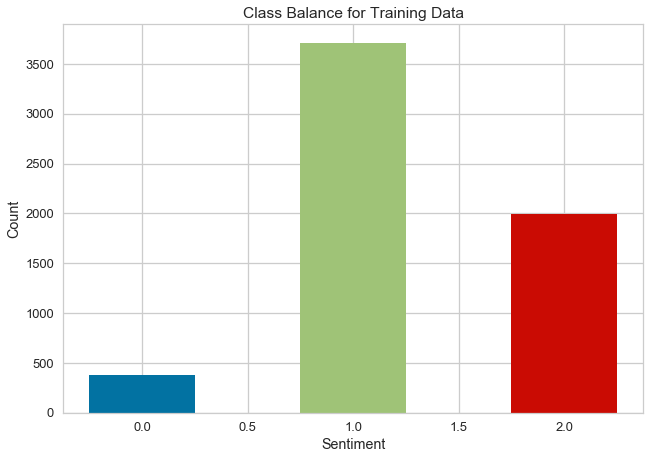

In [110]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative","Neutral", "Positive"])
ax = plt.gca()
ax.set_title("Class Balance for Training Data")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")

visualizer.fit(y_train)
plt.show()

# SVC Base Model for Comparison

In [111]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.48      0.27      0.35       188
           1       0.73      0.80      0.76      1830
           2       0.59      0.53      0.56       983

    accuracy                           0.68      3001
   macro avg       0.60      0.53      0.55      3001
weighted avg       0.67      0.68      0.67      3001



### Interpretation: 
A Cohen Kappa of .34 is beginning to look moderately reliable, based on the evaluations of kappa proposed by [tbd]

In [112]:
svc_cohen = cohen_kappa_score(y_test, y_pred)

print(svc_cohen)

0.3445035037018823


## Balanced SVC

In [113]:
clf = LinearSVC(class_weight="balanced", random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.43      0.35      0.38       188
           1       0.74      0.77      0.75      1830
           2       0.58      0.55      0.57       983

    accuracy                           0.67      3001
   macro avg       0.58      0.56      0.57      3001
weighted avg       0.67      0.67      0.67      3001



### Interpretation: 
Balancing the classes does not seem to improve the Cohen's Kappa in this instance so it will be maintained as good practice in an imbalanced scenario.

In [114]:
svc_bal_cohen = cohen_kappa_score(y_test, y_pred)

print(svc_cohen)

0.3445035037018823


# Tuning SVC via. GridSearchCV
Tuning C, tolerance, and maximum iterations.

In [115]:
from sklearn.model_selection import GridSearchCV

In [116]:
param_grid = {'C': [0.1,1, 10, 100],'tol': [1e-3, 1e-4, 1e-5],
                        'max_iter': [1000, 10000]}

In [117]:
grid = GridSearchCV(LinearSVC(class_weight="balanced", random_state=0),param_grid,refit=True,verbose=2, scoring=kappa_scorer, n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   55.3s finished


GridSearchCV(estimator=LinearSVC(class_weight='balanced', random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [1000, 10000],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring=make_scorer(cohen_kappa_score), verbose=2)

In [118]:
print(grid.best_estimator_)

LinearSVC(C=0.1, class_weight='balanced', random_state=0, tol=0.001)


In [119]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.43      0.38      0.40       188
           1       0.74      0.79      0.76      1830
           2       0.62      0.56      0.59       983

    accuracy                           0.69      3001
   macro avg       0.59      0.58      0.58      3001
weighted avg       0.68      0.69      0.68      3001



### Interpretation:
Grid searching has a small but noticeable effect with a balanced Linear SVC on the base dataset.

In [120]:
grid_bal_cohen = cohen_kappa_score(y_test, grid_predictions)
print(grid_bal_cohen)

0.3807338652319615


In [121]:
X.shape

(9092, 9841)

# Non-SVM Models

## Naive Bayes

In [122]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.04      0.08       188
           1       0.69      0.86      0.77      1830
           2       0.59      0.44      0.50       983

    accuracy                           0.67      3001
   macro avg       0.59      0.44      0.45      3001
weighted avg       0.65      0.67      0.64      3001



In [123]:
cohen_kappa_score(y_test, y_pred)

0.2793923890311658

In [124]:
from sklearn.naive_bayes import ComplementNB

clf = ComplementNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.27      0.35      0.30       188
           1       0.74      0.73      0.74      1830
           2       0.57      0.54      0.56       983

    accuracy                           0.65      3001
   macro avg       0.53      0.54      0.53      3001
weighted avg       0.65      0.65      0.65      3001



In [125]:
cohen_kappa_score(y_test, y_pred)

0.3251383833478333

## SGDClassifier

In [126]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.48      0.30      0.37       188
           1       0.74      0.77      0.75      1830
           2       0.58      0.56      0.57       983

    accuracy                           0.67      3001
   macro avg       0.60      0.55      0.57      3001
weighted avg       0.67      0.67      0.67      3001



In [127]:
cohen_kappa_score(y_test, y_pred)

0.35166067204275486

## On other models: 
Linear SVC seems to outperform several other standard models for text classification on this dataset, with ComplementNB and SGDClassifier close behind.

# Feature Selection - K Best - TBD: Iterate through n of features
Selecting 3000 features as a smaller but still large feature set to begin with.

In [128]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
fs = SelectKBest(score_func=f_classif, k=3000)
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(9092, 3000)


In [129]:
y = clean_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.33, random_state=42,stratify=y)

In [130]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

# Best model: Feature selected, grid searched LinearSVC

In [131]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   26.5s finished


GridSearchCV(estimator=LinearSVC(class_weight='balanced', random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [1000, 10000],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring=make_scorer(cohen_kappa_score), verbose=2)

In [132]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.44      0.38      0.41       188
           1       0.76      0.82      0.79      1830
           2       0.66      0.59      0.62       983

    accuracy                           0.71      3001
   macro avg       0.62      0.60      0.61      3001
weighted avg       0.71      0.71      0.71      3001



## .434 Cohen's Kappa Score, highest achieved

In [133]:
grid_bal_cohen = cohen_kappa_score(y_test, grid_predictions)
print(grid_bal_cohen)

0.4316814127612295


In [134]:
best = grid.best_estimator_

# Examination of feature importance on best model

In [135]:
coef = best.coef_.ravel()
top_features = 20
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]

In [136]:
top_positive_coefficients

array([ 707,  764, 1602, 1093,  744,  413, 1222, 8903, 1857, 7110, 8338,
       2439, 7585,  871, 2175, 1488, 1221, 7157,  948, 6593])

In [137]:
feature_names = mapper.transformed_names_

feature_names[:11]

['text_02',
 'text_03',
 'text_0310apple',
 'text_0610',
 'text_10',
 'text_100',
 'text_1000',
 'text_10000',
 'text_100000',
 'text_100tc',
 'text_101']

In [138]:
top_positive_coefficients= np.array(top_positive_coefficients)
feature_names = np.array(feature_names)

## Interpretation:
Oddly, occurrence of words and other metrics used for summary statistics and word visualization before do not seem to match up with positive and negative sentiment coefficients, with few exceptions(appletakingoverworld, nonapple) of linked phrases, instead contextualizing the tweets and what is being said **about** Apple and Google products.

In [139]:
feature_names[top_positive_coefficients]

array(['text_apartmovie', 'text_approved', 'text_cautiously',
       'text_beating', 'text_applestore', 'text_ackward', 'text_blanc',
       'text_trumping', 'text_coded', 'text_remake',
       'text_sxsurrogatescom', 'text_designed', 'text_sh',
       'text_attendong', 'text_cream', 'text_c40', 'text_blame',
       'text_rescuing', 'text_awake', 'text_posible'], dtype='<U40')

In [140]:
pos_feat_names = np.array([x.split('_') for x in feature_names[top_positive_coefficients].ravel()])
pos_feat_names =[i[1] for i in pos_feat_names]

pos_feat_names

['apartmovie',
 'approved',
 'cautiously',
 'beating',
 'applestore',
 'ackward',
 'blanc',
 'trumping',
 'coded',
 'remake',
 'sxsurrogatescom',
 'designed',
 'sh',
 'attendong',
 'cream',
 'c40',
 'blame',
 'rescuing',
 'awake',
 'posible']

In [141]:
top_negative_coefficients = np.argsort(coef)[:top_features]
feature_names[top_negative_coefficients]

array(['text_garageband', 'text_hoffman', 'text_ios5', 'text_obs',
       'text_improvement', 'text_marathon', 'text_hijacked',
       'text_nongoogle', 'text_fantasy', 'text_ncbshow', 'text_own',
       'text_hits', 'text_festgoers', 'text_feature', 'text_commercial',
       'text_hysterical', 'text_fast', 'text_eats', 'text_h4ackers',
       'text_hallway'], dtype='<U40')

In [142]:
neg_feat_names = np.array([x.split('_') for x in feature_names[top_negative_coefficients].ravel()])
neg_feat_names =[i[1] for i in neg_feat_names]

neg_feat_names

['garageband',
 'hoffman',
 'ios5',
 'obs',
 'improvement',
 'marathon',
 'hijacked',
 'nongoogle',
 'fantasy',
 'ncbshow',
 'own',
 'hits',
 'festgoers',
 'feature',
 'commercial',
 'hysterical',
 'fast',
 'eats',
 'h4ackers',
 'hallway']

## Feature importance - top positive coefficients

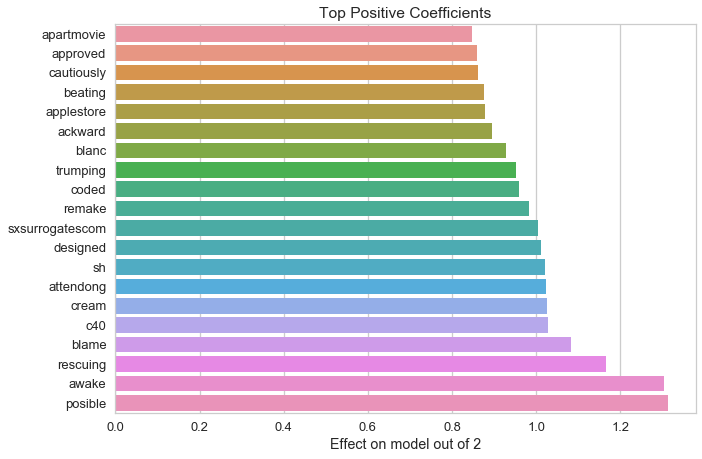

In [143]:
ax = sns.barplot( coef[top_positive_coefficients],feature_names[top_positive_coefficients],)
ax.set_yticklabels(pos_feat_names)
ax.set_xlabel("Effect on model out of 2")
ax.set_title("Top Positive Coefficients")
plt.show()

## Interpretation of positive text:
Here it is shown that the social network did in fact contribute to positive coefficients, along with the popup store and the iPad2. Google's ACLU party, Spark being given an award for positive sentiment about Android, and mislabeled negative sentiment about Marissa Mayer and JC Penney locations are being rerouted to Macys in Google maps stand out as new factors. **NOTE: Some text features, being derived from preprocessed text, do not appear in the original dataframe.**

In [144]:
for c in feature_names[top_positive_coefficients]:
    print("Text feature: " + c.split("_",1)[-1] + "\n --- \n")
    features = df[df['text'].str.contains(c.split('_')[1])]['text'][:6]
    for f in features:
        print(f + "\n")

Text feature: apartmovie
 --- 

Text feature: approved
 --- 

Awesome! First day of #SXSW and #Apple just approved our new app!!! Go and download it now and check our blog for &quot;Big Stereo&quot; #ipad2

Registration to Android market has been approved! #lmndst #sxsw #startupbus

RT @mention Awesome! First day of #SXSW and #Apple just approved our new app!!! Go and download it now and check our blog for &quot;Big Stereo&quot; #ipad2

Text feature: cautiously
 --- 

sure to be a total scene! RT @mention Just spoke with the Austin Apple store They are cautiously optimistic #nerd #sxsw

RT @mention sure to be a total scene! RT @mention Just spoke with the Austin Apple store They are cautiously optimistic #nerd #sxsw

Text feature: beating
 --- 

Server Challenge is a huge hit at #sxsw! Come by booth 400 to try your hand Win an iPhone 4 bottle opener case by beating 2 mins

RT @mention Server Challenge is a huge hit at #sxsw! Come by booth 400 to try your hand Win an iPhone 4 bottle ope

## Feature importance - top negative coefficients

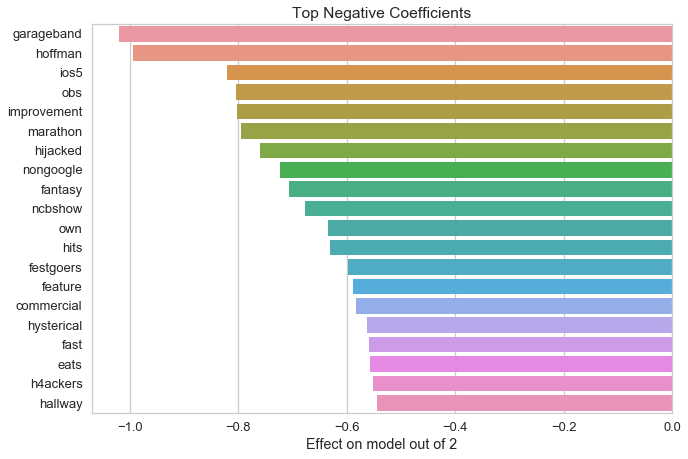

In [145]:
ax = sns.barplot( coef[top_negative_coefficients],feature_names[top_negative_coefficients],)
ax.set_yticklabels(neg_feat_names)
ax.set_xlabel("Effect on model out of 2")
ax.set_title("Top Negative Coefficients")
plt.show()

### Interpretation:
Standing out are design critiques of the iPad 2, mislabeled text praising Google's navigation, and generally that the negative coefficients seem to be less accurate and less common-sense negative than the positive ones, which makes sense given the difficulty predicting this minority class.

In [146]:
for c in feature_names[top_negative_coefficients]:
    print("Text feature: " + c.split("_",1)[-1] + "\n --- \n")
    features = df[df['text'].str.contains(c.split('_')[1])]['text'][:6]
    for f in features:
        print(f + "\n")

Text feature: garageband
 --- 

Text feature: hoffman
 --- 

Text feature: ios5
 --- 

Text feature: obs
 --- 

#technews At SXSW Apple schools the marketing experts link #Tech_News #Apple #Jobs_Co #SXSW #tech

Cus!
It's between pacman google singularity or #sxsw noobs meetup

Jeez guys dunno about an Apple popup over a Gold's Gym Do u realize how unJobsaesthetic that is? #SXSW #Apple

I'm a bit jealous seeing #SXSW attendees with #ipad2 My iPad seems so obsolete

Listening to some Google marketers speak Based on the crowd and what they're all holding Steve Jobs is wealthier than I thought #SXSW

ÛÏ@mention We'll be spotlighting all our new #mobile apps @mention #sxsw ; here's a peak at our iPad #jobsearch app video link

Text feature: improvement
 --- 

The iPad 2 is just a better product They have had time to make worthwhile improvements @mention Diller #SXSW

just got mine ; i disagree RT  @mention Peter Cashmore on iPad 2 it's only a minor improvement Not worth it unless you've $ 

# Undersampling techniques

In [147]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [148]:
from imblearn.under_sampling import NearMiss # doctest: +NORMALIZE_WHITESPACE
print('Original dataset shape %s' % Counter(y))
nm = NearMiss()
X_res, y_res = nm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 5544, 2: 2978, 0: 570})
Resampled dataset shape Counter({0: 382, 1: 382, 2: 382})


In [149]:
model = LinearSVC(class_weight="balanced", random_state=0)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.24      0.49      0.32       188
           1       0.70      0.44      0.54      1830
           2       0.41      0.60      0.48       983

    accuracy                           0.50      3001
   macro avg       0.45      0.51      0.45      3001
weighted avg       0.57      0.50      0.51      3001



In [150]:
bal_nm_cohen = cohen_kappa_score(y_test,y_pred)
print(bal_nm_cohen)

0.15776136568930144


## Grid search on undersampling

In [151]:
grid.fit(X_res,y_res)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.8s finished


GridSearchCV(estimator=LinearSVC(class_weight='balanced', random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [1000, 10000],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring=make_scorer(cohen_kappa_score), verbose=2)

In [152]:
print(grid.best_estimator_)

LinearSVC(C=0.1, class_weight='balanced', random_state=0, tol=0.001)


In [153]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.19      0.61      0.29       188
           1       0.74      0.44      0.55      1830
           2       0.42      0.56      0.48       983

    accuracy                           0.49      3001
   macro avg       0.45      0.54      0.44      3001
weighted avg       0.60      0.49      0.51      3001



In [154]:
grid_nm_cohen = cohen_kappa_score(y_test, grid_predictions)
print(grid_nm_cohen)

0.1831452280229552


# Other undersampling techniques - 
NeighbourhoodCleaningRule is computationally expensive, and produces results that don't outperform the dataset with no resampling, like the other undersampling techniques.

In [155]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule()
X_resampled, y_resampled = ncr.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 382), (1, 3333), (2, 459)]


In [156]:
model = LinearSVC(class_weight="balanced", random_state=0)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.37      0.36      0.36       188
           1       0.67      0.91      0.77      1830
           2       0.72      0.23      0.34       983

    accuracy                           0.65      3001
   macro avg       0.58      0.50      0.49      3001
weighted avg       0.66      0.65      0.61      3001



In [157]:
bal_ncr_cohen = cohen_kappa_score(y_test, grid_predictions)
print(bal_ncr_cohen)

0.1831452280229552


## Tuned SVC on NCR

In [158]:
grid.fit(X_resampled,y_resampled)
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s


              precision    recall  f1-score   support

           0       0.37      0.36      0.36       188
           1       0.67      0.91      0.77      1830
           2       0.72      0.23      0.34       983

    accuracy                           0.65      3001
   macro avg       0.58      0.50      0.49      3001
weighted avg       0.66      0.65      0.61      3001



[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.0s finished


In [159]:
tune_ncr_cohen = cohen_kappa_score(y_test, grid_predictions)

In [160]:
print(tune_ncr_cohen)

0.23363348143670737


# TBD: Conclusions - 

## TBD: chart of model performance

## Best model results and interpretation
### Results: 
- A score of .434 with Cohen's Kappa was achieved using a grid searched Linear Support Vector Machined Classifier in a heavily reduced feature space through feature selection with Select K Best. This is a fair or moderately reliable score.
- This classifier struggled, even with weighting of classes, stratification, attempts at resapling through undersampling and more, with the heavy imbalance in the data. 
- All other classifiers struggled with the imbalance as well, the key impedement to performance in classification in this task. 
- Complement NB and SGD Classifier also performed well, but issues with balancing class weights' feasability and time of training for grid searching prevented further exploration and established Linear SVC as the best model for the use case. 
- Moving forward with this project and model, I would seek to better address imbalance.

### Interpretation: 
- Interpretation was made difficult by performance issues, especially on the negative class, and its low support. 
- With that said, trends emerged: the big showings of Apple and Google respectively with their popup store along with the iPad 2 and the rumored Circles social network contributed to positive ratings, while design critiques of the iPad 2 stood out in the negative class. 

## Business recomendations:

### 1. Go Big: 
- The trends that stood out in the data were big showings by Apple and Google during an important event. It is crucial to capitalize on hype and make bold moves during periods like SXSW: whether it be drumming up the launch of a new social network or creating a popup store. 

### 2. Data Integrity: 
- The analysis was heavily compromised by data issues. Data collection and labeling must be done with an eye towards class balance and adequate support. 

### 3. Focus on the reliable Positives: 
- As the data had more positive occurrences and the classifier performed weakly on the negative class, focus on what data you can reliably classify. A good example of fostering positive sentiment was Google throwing their ACLU party, which was reliably classified as garnering positive responses.

# Future work: 
## Outlier detection approaches:
- Imbalanced learning can be treated as an outlier detection problem. 
- I would like to explore this through techniques such as Isolation Forest. 
- As well, I would look into adding additional features based off of the outlier and inlier values produced by those techniques to boost model performance.

## Multilabel classification
- This dataset could have been posed as a multilabel classification problem, by using the feature regarding direction of the tweet. 
- I would like to examine the various approaches to multilabel classification and see if they yielded better or different results and in what sense. 